## Figures

- Figure 2D,E


## Required files

- `{model_dir}/deeplift.imp_score.h5`
- `{model_dir}/deeplift/dfi_subset.parq`

## Produced files

- Figure 2D
  - `{ddir}/figures/modisco/{exp}/n-instances-per-motif.pdf`
- Figure 2E
  - `{ddir}/figures/modisco/{exp}/n-motifs-per-region.pdf`
- track files
  - `{ddir}/www/paper/data/tracks/regions.bed`
  - `{ddir}/www/paper/data/tracks/motif-instances.bed`

In [6]:
from collections import OrderedDict
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

motifs = OrderedDict([
    ("Oct4-Sox2", 'Oct4/m0_p0'),
    ("Oct4", "Oct4/m0_p1"),
    ("Oct4-Oct4", "Oct4/m0_p6"),
    ("Sox2", "Sox2/m0_p1"),
    ("Nanog", "Nanog/m0_p1"),
    ("Nanog-partner", "Nanog/m0_p4"),
    ("Klf4", "Klf4/m0_p0"),
    ("Klf4-Klf4", "Klf4/m0_p5"),
    ("B-Box", "Oct4/m0_p5"),
    ("Zic3", "Nanog/m0_p2"),
    ("Essrb", "Oct4/m0_p16"),
])

## Export files

In [7]:
# Imports
from basepair.imports import *
import pyranges as pr
from basepair.modisco.pattern_instances import (multiple_load_instances, load_instances, filter_nonoverlapping_intervals, 
                                                plot_coocurence_matrix, align_instance_center, dfi2seqlets, annotate_profile)
from basepair.exp.paper.config import *
from basepair.cli.modisco import load_profiles
from basepair.preproc import rc_seq, dfint_no_intersection
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

# interval columns in dfi
interval_cols = ['example_chrom', 'pattern_start_abs', 'pattern_end_abs']

In [23]:
# figures dir
model_dir = models_dir / exp
fdir = Path(f'{ddir}/figures/modisco/{exp}/spacing/')
!mkdir -p {fdir}

In [9]:
from basepair.cli.imp_score import ImpScoreFile

isf = ImpScoreFile(model_dir / 'deeplift.imp_score.h5')

In [10]:
peaks_per_task = pd.value_counts(isf.data["/metadata/interval_from_task"][:])

In [11]:
task_map = {"O": "Oct4", "S": "Sox2", "N": "Nanog", "K": "Klf4"}
# Figure out the tasks from the name
tasks = [task_map[s] for s in exp.split(",")[2]]

In [12]:
dfi_subset = pd.read_parquet(f"{model_dir}/deeplift/dfi_subset.parq", engine='fastparquet')
dfi_subset['row_idx'] = np.arange(len(dfi_subset))

dfi_subset['Chromosome'] = dfi_subset.example_chrom
dfi_subset['Start'] = dfi_subset.pattern_start_abs
dfi_subset['End'] = dfi_subset.pattern_end_abs
dfi_subset_pr = pr.PyRanges(dfi_subset)

In [13]:
assert len(dfi_subset.pattern.unique()) == len(motifs)

In [14]:
dfi_subset_pr = pr.PyRanges(dfi_subset)

In [15]:
# duplicated number of instances
len(dfi_subset_pr)

397924

In [16]:
# non-duplicated number of instances
len(dfi_subset_pr.drop_duplicate_positions())

241005

In [17]:
dfi_subset.head()

,example_chrom,example_end,example_idx,example_interval_from_task,example_start,example_strand,imp/Klf4,imp/Nanog,imp/Oct4,imp/Sox2,imp_max,imp_max_task,imp_weighted,imp_weighted_cat,imp_weighted_p,match/Klf4,match/Nanog,match/Oct4,match/Sox2,match_max,match_max_task,match_weighted,match_weighted_cat,match_weighted_p,pattern,pattern_center,pattern_end,pattern_end_abs,pattern_len,pattern_name,pattern_short,pattern_start,pattern_start_abs,seq_match,seq_match_cat,seq_match_p,strand,tf,is_te,pattern_center_aln,pattern_strand_aln,row_idx,Chromosome,Start,End
0,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,0.9374,NaN,0.9374,Oct4,0.9374,high,0.8462,NaN,NaN,0.5077,NaN,0.5077,Oct4,0.5077,high,0.6886,Oct4/metacluster_0/pa...,430,438,122145515,16,Oct4-Sox2,Oct4/m0_p0,422,122145499,10.2722,high,0.6902,-,Oct4,False,429,-,0,chr3,122145499,122145515
1,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,1.5355,NaN,1.5355,Oct4,1.5355,high,0.9920,NaN,NaN,0.5287,NaN,0.5287,Oct4,0.5287,high,0.7992,Oct4/metacluster_0/pa...,451,459,122145536,16,Oct4-Sox2,Oct4/m0_p0,443,122145520,11.5528,high,0.9044,-,Oct4,False,450,-,1,chr3,122145520,122145536
2,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,1.2758,NaN,1.2758,Oct4,1.2758,high,0.9670,NaN,NaN,0.4219,NaN,0.4219,Oct4,0.4219,low,0.2234,Oct4/metacluster_0/pa...,492,500,122145577,16,Oct4-Sox2,Oct4/m0_p0,484,122145561,10.7122,high,0.7777,-,Oct4,False,491,-,2,chr3,122145561,122145577
3,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,1.0455,NaN,1.0455,Oct4,1.0455,high,0.9050,NaN,NaN,0.4155,NaN,0.4155,Oct4,0.4155,low,0.2005,Oct4/metacluster_0/pa...,534,542,122145619,16,Oct4-Sox2,Oct4/m0_p0,526,122145603,10.2722,high,0.6902,-,Oct4,False,533,-,3,chr3,122145603,122145619
4,chr2,52072742,5,Oct4,52071742,.,NaN,NaN,1.4742,NaN,1.4742,Oct4,1.4742,high,0.9890,NaN,NaN,0.5071,NaN,0.5071,Oct4,0.5071,high,0.6851,Oct4/metacluster_0/pa...,516,524,52072266,16,Oct4-Sox2,Oct4/m0_p0,508,52072250,9.2183,medium,0.4731,+,Oct4,False,517,+,4,chr2,52072250,52072266


In [18]:
dict(dfi_subset.pattern_name.value_counts())

{'Klf4': 103044,
 'Nanog': 76337,
 'Oct4': 74594,
 'Oct4-Sox2': 52475,
 'Sox2': 40193,
 'Zic3': 14927,
 'Oct4-Oct4': 12511,
 'B-Box': 7516,
 'Nanog-partner': 7066,
 'Essrb': 5353,
 'Klf4-Klf4': 3908}

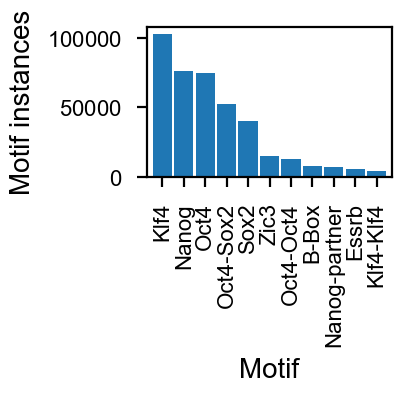

In [27]:
fig, ax = plt.subplots(figsize=get_figsize(0.23))
dfi_subset.pattern_name.value_counts().plot.bar(width=.9)
plt.ylabel("Motif instances")
plt.xlabel("Motif")
fig.savefig(fdir / '../n-instances-per-motif.pdf')

In [103]:
# Number of regions with a motif (total = 150k. Only 14k lack a motif)
len(dfi_subset.groupby('example_idx').size())

136302

In [104]:
dfi_subset.groupby('example_idx').size().value_counts()

2     35091
3     31293
1     27308
      ...  
17        1
25        1
30        1
Length: 23, dtype: int64

In [113]:
total_regions = len(ranges)

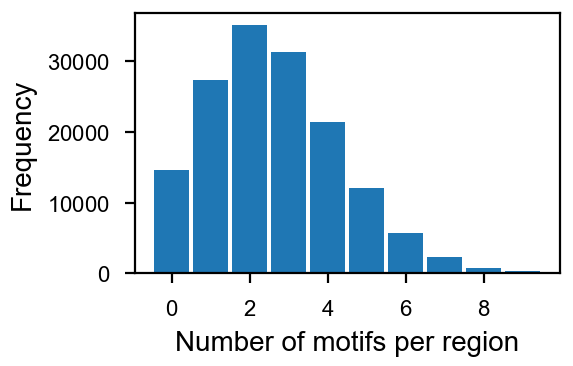

In [114]:
fig, ax = plt.subplots(figsize=get_figsize(0.4))
vec = dfi_subset.groupby('example_idx').size()
vec = pd.concat([vec, pd.Series(np.zeros(total_regions - len(vec)))])
vec.plot.hist(bins=np.arange(11), rwidth=0.9, align='left')
plt.xlabel("Number of motifs per region")
fig.savefig(fdir / '../n-motifs-per-region.pdf')

In [16]:
dfi_subset.head()

,example_chrom,example_end,example_idx,example_interval_from_task,example_start,example_strand,imp/Klf4,imp/Nanog,imp/Oct4,imp/Sox2,imp_max,imp_max_task,imp_weighted,imp_weighted_cat,imp_weighted_p,match/Klf4,match/Nanog,match/Oct4,match/Sox2,match_max,match_max_task,match_weighted,match_weighted_cat,match_weighted_p,pattern,pattern_center,pattern_end,pattern_end_abs,pattern_len,pattern_name,pattern_short,pattern_start,pattern_start_abs,seq_match,seq_match_cat,seq_match_p,strand,tf,is_te,pattern_center_aln,pattern_strand_aln
0,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,0.9374,NaN,0.9374,Oct4,0.9374,high,0.8462,NaN,NaN,0.5077,NaN,0.5077,Oct4,0.5077,high,0.6886,Oct4/metacluster_0/pa...,430,438,122145515,16,Oct4-Sox2,Oct4/m0_p0,422,122145499,10.2722,high,0.6902,-,Oct4,False,428,-
1,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,1.5355,NaN,1.5355,Oct4,1.5355,high,0.9920,NaN,NaN,0.5287,NaN,0.5287,Oct4,0.5287,high,0.7992,Oct4/metacluster_0/pa...,451,459,122145536,16,Oct4-Sox2,Oct4/m0_p0,443,122145520,11.5528,high,0.9044,-,Oct4,False,449,-
2,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,1.2758,NaN,1.2758,Oct4,1.2758,high,0.9670,NaN,NaN,0.4219,NaN,0.4219,Oct4,0.4219,low,0.2234,Oct4/metacluster_0/pa...,492,500,122145577,16,Oct4-Sox2,Oct4/m0_p0,484,122145561,10.7122,high,0.7777,-,Oct4,False,490,-
3,chr3,122146077,1,Oct4,122145077,.,NaN,NaN,1.0455,NaN,1.0455,Oct4,1.0455,high,0.9050,NaN,NaN,0.4155,NaN,0.4155,Oct4,0.4155,low,0.2005,Oct4/metacluster_0/pa...,534,542,122145619,16,Oct4-Sox2,Oct4/m0_p0,526,122145603,10.2722,high,0.6902,-,Oct4,False,532,-
4,chr2,52072742,5,Oct4,52071742,.,NaN,NaN,1.4742,NaN,1.4742,Oct4,1.4742,high,0.9890,NaN,NaN,0.5071,NaN,0.5071,Oct4,0.5071,high,0.6851,Oct4/metacluster_0/pa...,516,524,52072266,16,Oct4-Sox2,Oct4/m0_p0,508,52072250,9.2183,medium,0.4731,+,Oct4,False,518,+


In [198]:
19.535 / (212.63-196.32) * 0.3

0.3593194359288779

In [199]:
3.505 / (212.63-196.32) * 0.3

0.06446965052115265

In [18]:
dfi_subset.groupby(['pattern_name', 'example_idx']).size().reset_index()

,pattern_name,example_idx,0
0,B-Box,2,2
1,B-Box,4,2
2,B-Box,7,4
...,...,...,...
311598,Zic3,147928,1
311599,Zic3,147950,1
311600,Zic3,147966,1


In [ ]:
dfi_subset.head()

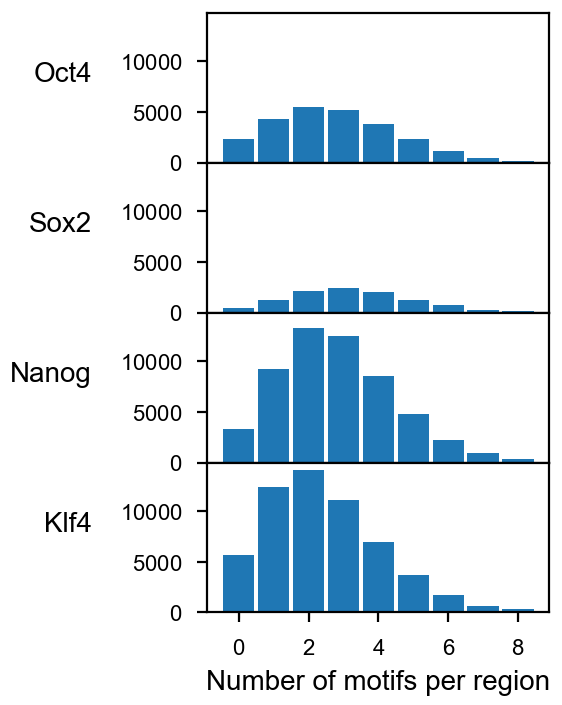

In [120]:
fig, axes = plt.subplots(len(tasks), 1, 
                         figsize=get_figsize(0.23*1.4, aspect=len(tasks)* 0.618/1.4),
                         sharey=True,
                         gridspec_kw=dict(hspace=0),
                         sharex=True)
for i, task in enumerate(tasks):
    ax = axes[i]
    vec = dfi_subset[dfi_subset.example_interval_from_task == task].groupby('example_idx').size()
    vec = pd.concat([vec, pd.Series(np.zeros(peaks_per_task[task] - vec.index.nunique()))])
    vec.plot.hist(bins=np.arange(10), rwidth=0.9, align='left', ax=ax)
    ax.set_ylabel(task, rotation=0, labelpad=10, ha='right')
ax.set_xlabel("Number of motifs per region")
fig.savefig(fdir / '../n-motifs-per-region.per-task.pdf')

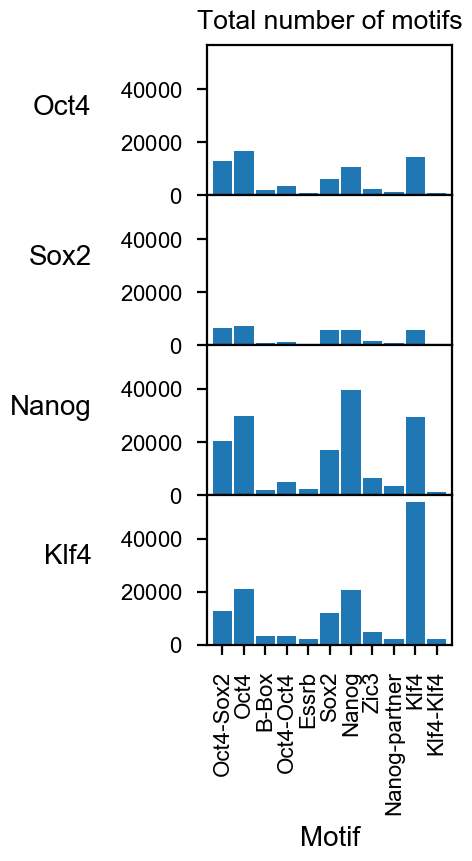

In [121]:
fig, axes = plt.subplots(len(tasks), 1, 
                         figsize=get_figsize(0.23, aspect=len(tasks)* 0.618),
                         sharey=True,
                         gridspec_kw=dict(hspace=0),
                         sharex=True)
pattern_names = dfi_subset.pattern_name.unique()
for i, task in enumerate(tasks):
    ax = axes[i]
    if i == 0:
        ax.set_title("Total number of motifs")
    vec = dfi_subset[dfi_subset.example_interval_from_task == task].pattern_name.value_counts().reindex(pattern_names, fill_value=0)
    vec.plot.bar(width=.9, ax=ax)
    ax.set_ylabel(task, rotation=0, labelpad=10, ha='right')
ax.set_xlabel("Motif")
fig.savefig(fdir / '../n-instances-per-motif.per-task.pdf')

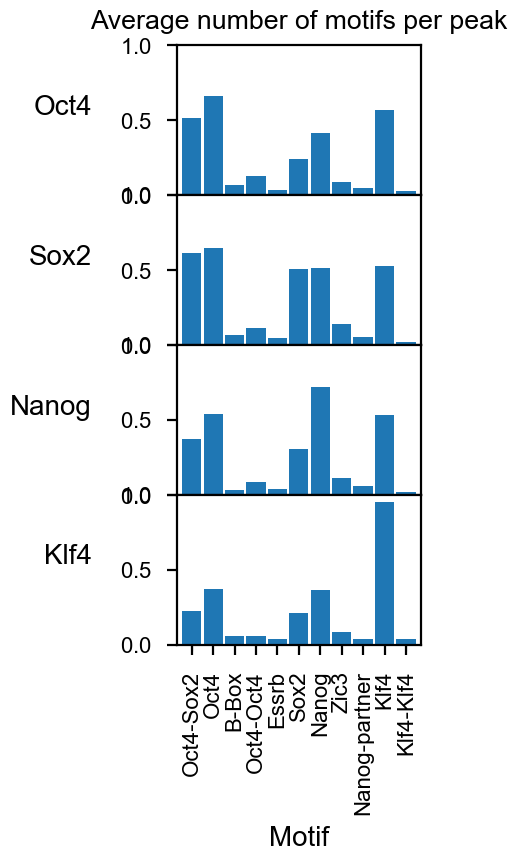

In [122]:
fig, axes = plt.subplots(len(tasks), 1, 
                         figsize=get_figsize(0.23, aspect=len(tasks)* 0.618),
                         sharey=True,
                         gridspec_kw=dict(hspace=0),
                         sharex=True)
pattern_names = dfi_subset.pattern_name.unique()
for i, task in enumerate(tasks):
    ax = axes[i]
    if i == 0:
        ax.set_title("Average number of motifs per peak")
    vec = dfi_subset[dfi_subset.example_interval_from_task == task].pattern_name.value_counts().reindex(pattern_names, fill_value=0)
    vec = vec / peaks_per_task[task]
    vec.plot.bar(width=.9, ax=ax)
    ax.set_ylabel(task, rotation=0, labelpad=10, ha='right')
ax.set_xlabel("Motif")

fig.savefig(fdir / '../n-instances-per-motif.per-task.avg-motifs-per-peak.pdf')

In [16]:
np.sum(dfi_subset.groupby('example_idx').size() >= 3)

72696

In [19]:
np.sum(dfi_subset.groupby('example_idx').size() >= 3) / 150908

0.4817239642696212

In [18]:
np.sum(dfi_subset.groupby('example_idx').size() >= 5)

20352

In [17]:
72696 / 150000

0.48464

### Export the files

In [32]:
tracks_dir = Path(ddir) / 'www/paper/data/tracks'
!mkdir -p {tracks_dir}

In [44]:
bed_cols = ['Chromosome', 'Start', 'End', 'pattern_name', 'match_weighted_p', 'strand', 'imp_weighted_p', 'seq_match_p']
duplicates = dfi_subset[bed_cols[:4]].duplicated()  # Drop duplicates
dfi_subset[~duplicates][bed_cols].sort_values(bed_cols[:2]).to_csv(tracks_dir / "motif-instances.bed", sep='\t', header=False, index=False)

In [45]:
!head {tracks_dir}/motif-instances.bed

chr1	3062902	3062942	Zic3	0.7825581395348837	+	0.977906976744186	0.9988372093023256
chr1	3062958	3062974	Sox2	0.8845577211394303	-	0.999000499750125	1.0
chr1	3062975	3063015	Zic3	0.2127906976744186	+	0.8854651162790698	0.17674418604651163
chr1	3062986	3062996	Klf4	0.32804637934806385	-	0.65970247210676	0.08663312185517393
chr1	3343656	3343665	Nanog	0.656429294633817	-	0.41444481943975703	0.16199797502531219
chr1	3344270	3344279	Nanog	0.3742828214647317	-	0.7789402632467094	0.44954438069524133
chr1	3344273	3344289	Sox2	0.9960019990004998	+	0.5822088955522239	1.0
chr1	3344308	3344348	Zic3	0.8715116279069768	-	0.7127906976744186	1.0
chr1	3344361	3344376	Nanog-partner	0.20212765957446807	+	0.06648936170212766	0.013297872340425532
chr1	3344401	3344410	Nanog	0.2291596355045562	-	0.27505906176172795	0.14039824502193723


In [46]:
!wc -l {tracks_dir}/motif-instances.bed

241005 /users/avsec/workspace/basepair/data/www/paper/data/tracks/motif-instances.bed


In [49]:
# write out the region
ranges = isf.get_ranges()
ranges[['chrom', 'start', 'end', 'interval_from_task']].to_csv(tracks_dir / "regions.bed", sep='\t', header=False, index=False)

In [54]:
!wc -l {tracks_dir}/regions.bed

147974 /users/avsec/workspace/basepair/data/www/paper/data/tracks/regions.bed
